# Dementia diagnosis using mmse results and AI
- mmse stands for **Mini-Mental State Examination**
- It is an 11-question measure that tests five areas of cognitive function:
orientation, registration, attention and calculation, recall, and language
- The maximum mmse score is 30
- 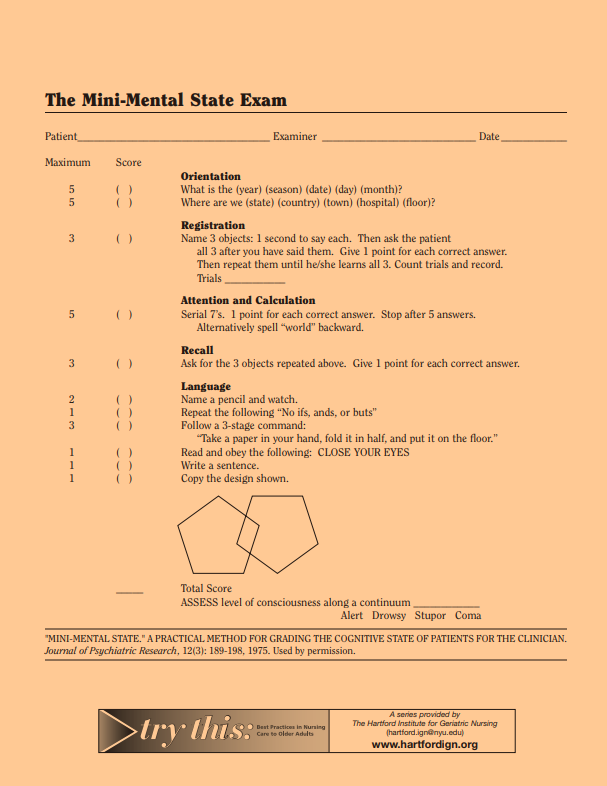
- Is there a better way for diagnosis than simply using a threshold value?
    We will find out!
## Preprocessing

In [9]:
import pandas as pd

mmse = pd.read_csv('./data/mmse.csv')
CRITERIA = ['MMDATE', 'MMYEAR', 'MMMONTH', 'MMDAY',
       'MMSEASON', 'MMHOSPIT', 'MMFLOOR', 'MMCITY', 'MMAREA', 'MMSTATE',
        'WORD1', 'WORD2', 'WORD3', 'MMD', 'MML', 'MMR',
       'MMO', 'MMW', 'WORD1DL', 'WORD2DL', 'WORD3DL',
       'MMWATCH', 'MMPENCIL', 'MMREPEAT', 'MMHAND', 'MMFOLD', 'MMONFLR',
       'MMREAD', 'MMWRITE', 'MMDRAW']
CRITERIA_NUM= len(CRITERIA)
print(CRITERIA_NUM)
mmse = mmse[['VISDATE', 'PTID']+CRITERIA].dropna()
mmse.to_csv('cleaned_data/mmse_clean.csv', index=False)

30


In [10]:
diagnosis = pd.read_csv('./data/diagnosis.csv')
diagnosis = diagnosis[['EXAMDATE','PTID','DIAGNOSIS']].rename(columns={'EXAMDATE': 'DATE'}).dropna()
diagnosis['DIAGNOSIS'] = diagnosis['DIAGNOSIS']-1
diagnosis.to_csv('./cleaned_data/diagnosis_clean.csv', index=False)
diagnosis.rename(columns={'DATE': 'VISDATE'}, inplace=True)
mmse = pd.merge(mmse, diagnosis, on=['PTID','VISDATE'] , how='inner')
mmse['SCORE'] = mmse[CRITERIA].sum(axis=1)

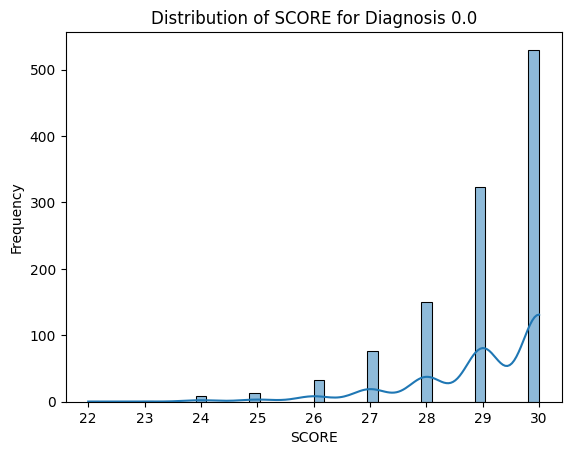

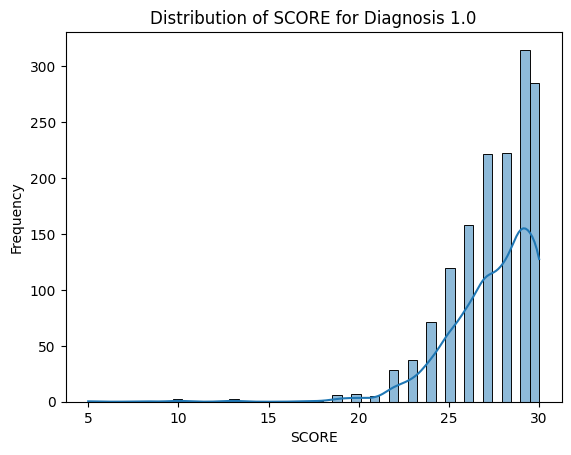

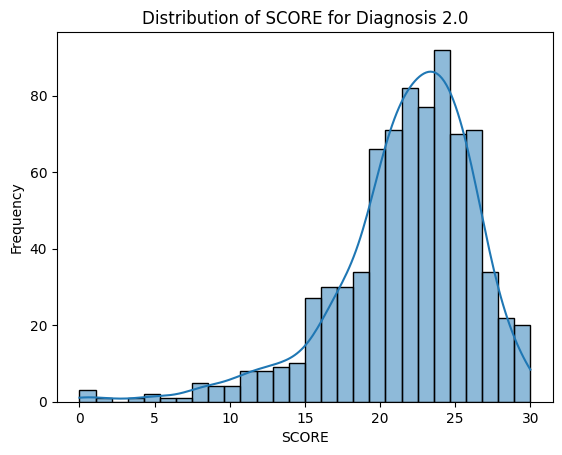

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group the npiq dataframe by the "DIAGNOSIS" column
grouped_df = mmse.groupby("DIAGNOSIS")

# Iterate over each diagnosis group
for diagnosis, group in grouped_df:
    # Create a figure and axes for the plot
    fig, ax = plt.subplots()
    
    # Plot the distribution of "SCORE" for the current diagnosis group
    sns.histplot(data=group, x="SCORE", kde=True, ax=ax)
    
    # Set the title and labels for the plot
    ax.set_title(f"Distribution of SCORE for Diagnosis {diagnosis}")
    ax.set_xlabel("SCORE")
    ax.set_ylabel("Frequency")
    
    # Show the plot
    plt.show()


## Modeling
- We will find the normal distribution parameters for each diagnosis (mean and std)
- Then we will use the parameters to calculate the probability of each diagnosis given mmse score
- P(Diagnosis∣SCORE)= P(SCORE∣Diagnosis)⋅P(Diagnosis)/P(SCORE)

In [11]:
from bayesian import *

weights = np.ones(len(CRITERIA))
mmse['SCORE'] = mmse[CRITERIA].sum(axis=1)
max_score = 30
print(parameters4censored_data(mmse['SCORE'],min_score=0, max_score=max_score))
print(parameters4each_class(mmse,min_score=0, max_score=max_score))
print(mmse['SCORE'].describe())

[27.75555326890735, 4.76052410648169]
{0.0: [29.937892128290457, 1.7376156444410862], 1.0: [28.13277826519821, 2.592342328681736], 2.0: [22.242063777766187, 4.605739380613655]}
count    3405.000000
mean       26.626138
std         3.969518
min         0.000000
25%        25.000000
50%        28.000000
75%        29.000000
max        30.000000
Name: SCORE, dtype: float64


In [12]:
labels = mmse['DIAGNOSIS'].values.astype(int)  # Ensure labels are integers from 0 to num_classes - 1
ground_truth = np.eye(len(mmse['DIAGNOSIS'].unique()))[labels]  # One-hot encode the labels
class_priors = mmse['DIAGNOSIS'].value_counts(normalize=True)
print(class_priors)

DIAGNOSIS
1.0    0.436123
0.0    0.333921
2.0    0.229956
Name: proportion, dtype: float64


In [13]:
# bounds = [(1, 10) for _ in CRITERIA]
# Initial weights
# # result = minimize(
# #     classifier_loss2, 
# #     weights, 
# #     args=(mmse, CRITERIA, 1, ground_truth, class_priors),
# #     bounds=bounds
# #     ,method='Powell')

# result= minimize(
#     classifier_loss, 
#     weights, 
#     args=(mmse, CRITERIA, 1),
#     bounds=bounds
#     ,method='Powell')

# weights = result.x


In [14]:
from sklearn.metrics import accuracy_score
max_score= weights.sum()
accuracy = accuracy_score(mmse['DIAGNOSIS'], bayesian_classifier(mmse,max_score=max_score,class_priors=class_priors))

print(accuracy)
# print(mmse['DIAGNOSIS'])
# print(mmse['SCORE'])

# print(posterior_probability(mmse, max_score))

0.6232011747430249


In [19]:
from flaml import AutoML
automl = AutoML()

# Specify the estimators you want to test
estimators_to_test = ['lgbm', 'lrl1','xgboost','rf', 'extra_tree', 'lrl2']

# Iterate over each estimator
for estimator in estimators_to_test:
    print(f"\nTesting estimator: {estimator}")
    
    # Configure AutoML for each estimator
    automl_settings = {
        "task": 'classification',
        "estimator_list": [estimator],  # Test one estimator at a time
        "verbose": 0,  # silent mode
    }

    # Train the model
    automl.fit(X_train=mmse['SCORE'].to_numpy() , y_train=mmse['DIAGNOSIS'].to_numpy() , **automl_settings)

    # Make predictions
    y_pred = automl.predict(mmse['SCORE'].to_numpy().reshape(-1, 1))

    # Calculate accuracy
    accuracy = accuracy_score(mmse['DIAGNOSIS'].to_numpy() , y_pred)
    print(f"Accuracy for {estimator}: {accuracy:.4f}")



Testing estimator: lgbm
Accuracy for lgbm: 0.6294

Testing estimator: lrl1
Accuracy for lrl1: 0.6206

Testing estimator: xgboost


c:\Users\yeon0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Accuracy for xgboost: 0.6294

Testing estimator: rf
Accuracy for rf: 0.6294

Testing estimator: extra_tree
Accuracy for extra_tree: 0.6294

Testing estimator: lrl2
Accuracy for lrl2: 0.6294
